In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np


In [2]:
dim_input = 1

class NNApproximator(nn.Module):
  def __init__(self, dim_input = 1, dim_output = 1, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
    super().__init__()

    self.layer_in = nn.Linear(dim_input, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, dim_output)

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.activation = activation

  def forward(self, t):
    out = self.activation(self.layer_in(t))
    for layer in self.middle_layers:
      out = self.activation(layer(out))
    return self.layer_out(out)

In [3]:
def f(model, t):
  """Evaluate a neural network with the input x."""
  return model.forward(t)

def df(model, t, order=1):
  """Compute the neural network's derivative wrt the input, x, using autograd."""
  df_value = f(model, t)
  for _ in range(order):
    df_value = torch.autograd.grad(
        outputs=df_value,
        inputs=t,
        grad_outputs=torch.ones_like(t),
        create_graph=True,
        retain_graph=True,
    )[0]

  # TODO: need to figure out what the [0] is for, and why the Jv product uses v=ones()

  return df_value

def compute_PINN_loss(model, t):
  omega = 1.8
  t_bc = 0.0      # input value where boundary condition is specified
  x_bc = 1.0      # value of x = A*sin(wt) + B*cos(wt) at the boundary
  xdot_bc = 1.0   # value of xdot at the boundary

  # calculate ODE residual at collocation points

  # using training data... the canonical method is NOT to do this, but use the NN's variables wherever possible.
  # ode_residual = df(model, t, order=2) + omega**2 * x_tr
  # Since the NN predicts x(t), we should use model.forward(t) instead of the training data x_tr.
  x_nn     = f(model, t)
  xddot_nn = df(model, t, order=2)
  xdot_nn  = df(model, t, order=1)
  ode_residual = xddot_nn + omega**2 * x_nn
  ode_loss = 0.5 * torch.mean(ode_residual ** 2)

  # apply energy conservation loss
  E0 = (omega**2) * x_bc**2 + xdot_bc**2
  E  = (omega**2) * x_nn**2 + xdot_nn**2
  energy_loss = 0.5 * torch.mean((E0 - E) ** 2)

  # calculate loss to match boundary condition
  t_bc = torch.tensor([t_bc], requires_grad=True)
  x_bc = torch.tensor([x_bc], requires_grad=False)
  x_bc_nn = f(model, t_bc)
  xdot_bc_nn = df(model, t_bc, order=1)
  bc_loss = 0.5 * (x_bc_nn - x_bc) ** 2 + 0.5 * (xdot_bc_nn - xdot_bc) ** 2

  return ode_loss + bc_loss + energy_loss

In [4]:
def compute_data_loss(model, t_tr, x_tr):
  return 0.5 * torch.mean((f(model, t_tr) - x_tr) ** 2)

In [18]:
def train_model(model, data_loss_fn, PINN_loss_fn, learning_rate=0.0001, max_epochs=1000):
  tr_losses = []
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(max_epochs):
    loss = data_loss_fn(model) + PINN_loss_fn(model)    # TODO: how/where to include x and data (y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")
    tr_losses.append(loss.detach().numpy())

  return model, np.array(tr_losses)

Epoch: 0 - Loss: 0.339107
Epoch: 1000 - Loss: 0.191529
Epoch: 2000 - Loss: 0.035967
Epoch: 3000 - Loss: 0.005493
Epoch: 4000 - Loss: 0.003112
Epoch: 5000 - Loss: 0.002779
Epoch: 6000 - Loss: 0.002976
Epoch: 7000 - Loss: 0.002699
Epoch: 8000 - Loss: 0.002677
Epoch: 9000 - Loss: 0.002669


Text(0.5, 1.0, 'Approximation error inside training domain')

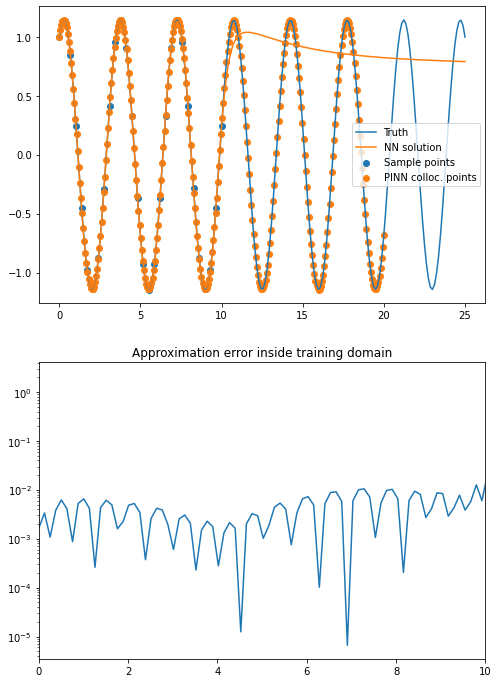

In [23]:
# analytical solution
x = lambda t: 1/1.8 * torch.sin(1.8 * t) + torch.cos(1.8 * t)

domain = [0.0, 10.0]

# data for NN solution to match
t_tr = torch.linspace(domain[0], domain[1], steps=30)
t_tr = t_tr.reshape(-1, 1)
x_tr = x(t_tr.detach())
x_tr.reshape(t_tr.shape)

# collocation points for ODE loss
# t_PINN requires grad because this is the NN's input vector for evaluating the ODE loss
t_tr_PINN = torch.linspace(domain[0], 2*domain[1], steps=300, requires_grad=True)
t_tr_PINN = t_tr_PINN.reshape(-1, 1)

nn_approximator = NNApproximator(1, 1, num_hidden=6, dim_hidden=30)
# assert check_gradient(nn_approximator, x)

nn_tr, tr_losses = train_model(
    nn_approximator,
    data_loss_fn=lambda model: compute_data_loss(model, t_tr, x_tr),
    PINN_loss_fn=lambda model: 1e-3*compute_PINN_loss(model, t_tr_PINN),
    learning_rate=0.0001,
    max_epochs=10000,
)

domain_te = [0.0, 25.0]
t_te = torch.linspace(domain_te[0],domain_te[1],steps=200).reshape(-1,1)
x_te = x(t_te.detach())

fig, ax = plt.subplots(2,1, figsize=(8,12))
f_te = f(nn_tr, t_te)
ax[0].scatter(t_tr.detach().numpy(), x_tr.detach().numpy(), label='Sample points')
ax[0].scatter(t_tr_PINN.detach().numpy(), x(t_tr_PINN.detach()).detach().numpy(), label='PINN colloc. points')
ax[0].plot(t_te.detach().numpy(), x_te.detach().numpy(),label='Truth')
ax[0].plot(t_te.detach().numpy(), f_te.detach().numpy(), label='NN solution')
ax[0].legend()

ax[1].semilogy(t_te.detach().numpy(), np.abs(f_te.detach().numpy() - x_te.detach().numpy()))
ax[1].set_xlim(domain)
ax[1].set_title("Approximation error inside training domain")

In [7]:
def check_gradient(model, t):

    eps = 1e-4
    dfdx_fd = (f(model, t + eps) - f(model, t - eps)) / (2 * eps)
    dfdx_sample = df(model, t, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)

